# Предсказание будущих продажи

Задача: Вам предоставляются ежедневные исторические данные о продажах. Задача состоит в прогнозировании общего количества продуктов, проданных в каждом магазине для тестового набора. Обратите внимание, что список магазинов и товаров слегка меняется каждый месяц. Создание надежной модели, способной справиться с такими ситуациями, является частью проблемы.

Описание файлов
sales_train.csv - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года.
test.csv - тестовый набор. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.
sample_submission.csv - файл с примерами представления в правильном формате.
items.csv - дополнительная информация о товарах / товарах.
item_categories.csv - дополнительная информация о категориях товаров.
shops.csv- дополнительная информация о магазинах.
Поля данных

ID - идентификатор, который представляет кортеж (магазин, товар) в тестовом наборе
shop_id - уникальный идентификатор магазина
item_id - уникальный идентификатор товара
item_category_id - уникальный идентификатор категории товара
item_cnt_day - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры
item_price - текущая цена товара
дата - дата в формате дд / мм / гггг
date_block_num - порядковый номер месяца, используемый для удобства. В январе 2013 года - 0, в феврале 2013 года - 1, ..., в октябре 2015 года - 33
item_name - название предмета
shop_name - название магазина
item_category_name - название категории товара

Импорт основных необходимых библиотек

In [1]:
import numpy as np
from numpy.random import seed
from numpy.random import randn

import pandas as pd

from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set(style="whitegrid")

import math
%config IPCompleter.greedy=True

import csv
import time

Загрузка обучающих данных о продажах

In [2]:
sales_train = pd.read_csv(r'./datasets/sales_train.csv')
sales_test = pd.read_csv(r'./datasets/test.csv')

items = pd.read_csv(r'./datasets/items.csv')
item_cat = pd.read_csv(r'./datasets/item_categories.csv')
shops = pd.read_csv(r'./datasets/shops.csv')

Очистка и подготовка данных


In [3]:

sales_train.head (10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Проверим, содержат ли данные поезда и теста какие-либо пропущенные значения


In [5]:
sales_train[sales_train.isnull().any(axis = 1)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [7]:
sales_test[sales_test.isnull().any(axis = 1)].head()

,ID,shop_id,item_id


Проверим наличие каких-либо выбросов в данных

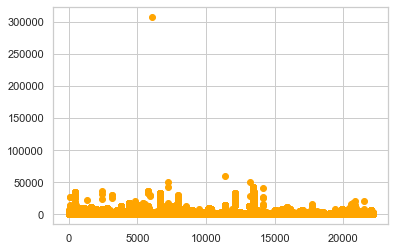

In [9]:
plt.plot(sales_train['item_id'], sales_train['item_price'], 'o', color='orange');

In [10]:
sales_train[sales_train.item_price > 250000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [11]:

items[items.item_id == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [12]:
item_cat[item_cat.item_category_id == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


In [13]:
shops[shops.shop_id == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


Получается, что запись, сначала показавшаяся выбросом, является реальной продажей

In [30]:
#  постановка для дальнейшего анализа
sales_train_sub = sales_train
sales_train_sub['date'] =  pd.to_datetime(sales_train_sub['date'],format= '%d.%m.%Y')
sales_train_sub['month'] = pd.DatetimeIndex(sales_train_sub['date']).month
sales_train_sub['year'] = pd.DatetimeIndex(sales_train_sub['date']).year
sales_train_sub = sales_train_sub.iloc[:,1:8]
sales_train_sub.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.00,1.0,1,2013
1,0,25,2552,899.00,1.0,1,2013
2,0,25,2552,899.00,-1.0,1,2013
3,0,25,2554,1709.05,1.0,1,2013
4,0,25,2555,1099.00,1.0,1,2013
5,0,25,2564,349.00,1.0,1,2013
6,0,25,2565,549.00,1.0,1,2013
7,0,25,2572,239.00,1.0,1,2013
8,0,25,2572,299.00,1.0,1,2013
9,0,25,2573,299.00,3.0,1,2013


### Decision Tree Classification

In [20]:
monthly_sales=sales_train_sub.groupby(["date_block_num","shop_id","item_id"])["item_cnt_day"].agg(item_cnt_day='sum')

monthly_sales['date_block_num'] = monthly_sales.index.get_level_values('date_block_num') 
monthly_sales['shop_id'] = monthly_sales.index.get_level_values('shop_id') 
monthly_sales['item_id'] = monthly_sales.index.get_level_values('item_id') 
monthly_sales.reset_index(drop=True, inplace=True)

monthly_sales = monthly_sales.reindex(['date_block_num','shop_id','item_id','item_cnt_day'], axis=1)
monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
5,0,0,61,1.0
6,0,0,75,1.0
7,0,0,88,1.0
8,0,0,95,1.0
9,0,0,96,1.0


In [21]:
from sklearn import tree
model_DTC = tree.DecisionTreeClassifier(criterion='gini') 

cols = ['shop_id','date_block_num','item_id']
X = monthly_sales[cols] # Predictor columns
y = monthly_sales.item_cnt_day  # Target variable

In [22]:
model_DTC.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
X_test_DTC = sales_test[['shop_id','item_id']]
X_test_DTC.insert(loc=1, column='date_block_num', value='34')  
X_test_DTC.head(10)

,shop_id,date_block_num,item_id
0,5,34,5037
1,5,34,5320
2,5,34,5233
3,5,34,5232
4,5,34,5268
5,5,34,5039
6,5,34,5041
7,5,34,5046
8,5,34,5319
9,5,34,5003


Прогнозирование с использованием классификатора дерева решений

In [27]:
predicted_raw_DTC= model_DTC.predict(X_test_DTC)

predicted_DTC = pd.DataFrame(predicted_raw_DTC)
predicted_DTC = predicted_DTC.join(X_test_DTC)

predicted_DTC.columns  = ['item_cnt', 'shop_id', 'date_block_num','item_id']
predicted_DTC = predicted_DTC.reindex(['shop_id','date_block_num','item_id','item_cnt'], axis=1)

print(predicted_DTC.head(10))

predicted_DTC.to_csv("./datasets/SalesTest_DecisionTreeClass.csv", sep=',')

   shop_id date_block_num  item_id  item_cnt
0        5             34     5037       1.0
1        5             34     5320       3.0
2        5             34     5233       1.0
3        5             34     5232       1.0
4        5             34     5268       1.0
5        5             34     5039       1.0
6        5             34     5041       2.0
7        5             34     5046       1.0
8        5             34     5319       3.0
9        5             34     5003       1.0


### Decision Tree Regressor

In [31]:
X2 = monthly_sales[cols] # Predictor columns
Y2 = monthly_sales.item_cnt_day  # Target variable

# Подгонка модели простой линейной регрессии к набору данных
from sklearn.tree import DecisionTreeRegressor
model_DTR = DecisionTreeRegressor(random_state = 0)
model_DTR.fit(X2, Y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [32]:
X2_test_DTR = sales_test[['shop_id','item_id']]
X2_test_DTR.insert(loc=1, column='date_block_num', value='34')


predicted_raw_DTR = pd.DataFrame(model_DTR.predict(X2_test_DTR))
predicted_raw_DTR = X2_test_DTR.join(predicted_raw_DTR)

predicted_raw_DTR.columns  = ['shop_id', 'date_block_num','item_id', 'item_cnt']
predicted_DTR = predicted_raw_DTR.reindex(['shop_id','date_block_num','item_id','item_cnt'], axis=1)

print(predicted_DTR.head(10))

predicted_DTR.to_csv("./datasets/SalesTest_DecisionTreeRegr.csv", sep=',')

   shop_id date_block_num  item_id  item_cnt
0        5             34     5037       1.0
1        5             34     5320       1.0
2        5             34     5233       1.0
3        5             34     5232       1.0
4        5             34     5268       1.0
5        5             34     5039       1.0
6        5             34     5041       2.0
7        5             34     5046       1.0
8        5             34     5319       1.0
9        5             34     5003       1.0


In [40]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


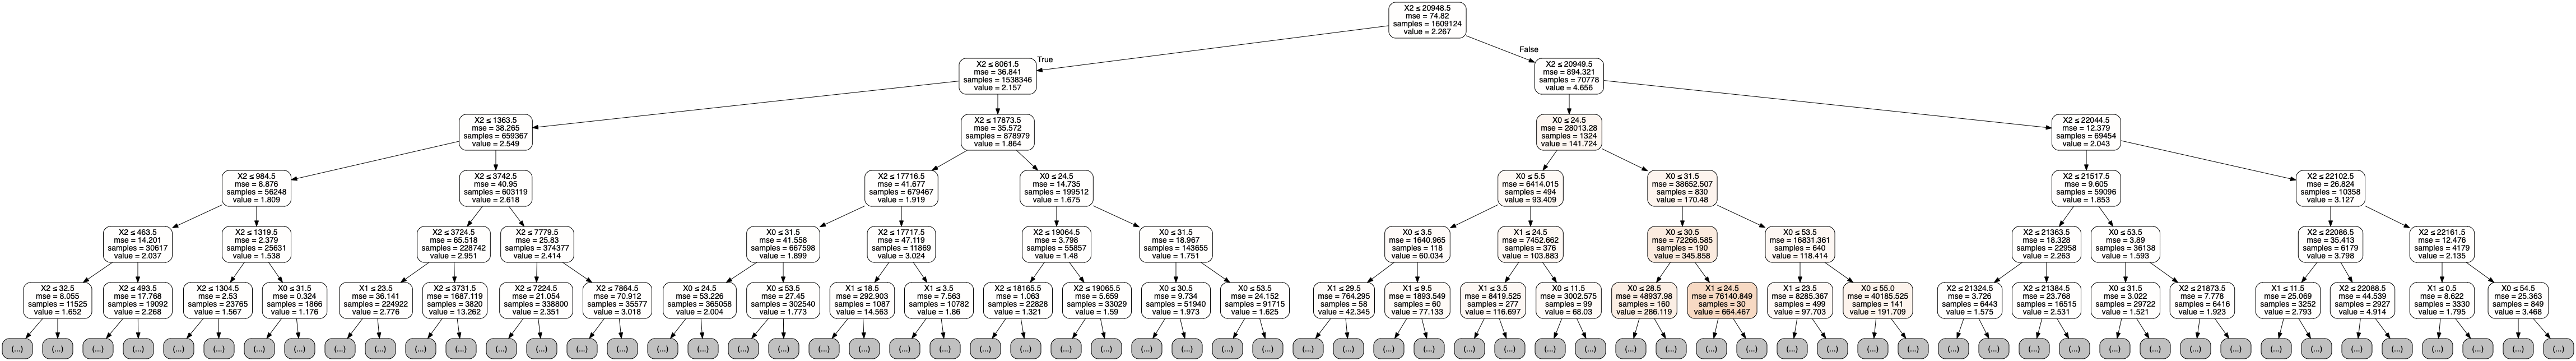

In [44]:
#visualizing decision tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(model_DTR, out_file=dot_data, max_depth=5,
filled=True, rounded=True,
special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())